# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import os
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, VectorAssembler #, OneHotEncoderEstimator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# create a Spark session
spark = SparkSession \
     .builder \
     .appName("Sparkify") \
     .getOrCreate()

In [3]:
#check spark installed spark version
print('Version: ', spark.version)

Version:  3.0.2


# Code Prep
In this workspace, all code that is used throughout the notebook is defined.

In [4]:
def load_data(path=''):
    """
    This function loads json data

    Args:
        - path (string): filepath to the data
    Returns:
        - data (json): spark json file
    """
    #create json data from filepath
    data = spark.read.json(path)

    return data

In [5]:
def clean_data(data):
    """
    This function cleans the dataset:
        - delete rows without userIds or sessionIds
        - cast userId to LongType
        - replace special characters of string columns with empty string
        - split ts into useable columns interaction_time, month, date
        - delete ts column
        - split location into seperate columns location, state

    Args:
        data (json): loaded json file
    Returns:
        cleaned_data (json): cleaned json file
    """
    #delete rows without userids or sessionids
    data = data.filter(col('userId').isNotNull() | col('sessionId').isNotNull())

    #cast userId to LongType
    data= data.withColumn("userId", data["userId"].cast(LongType()))

    #replace special characters of strings with empty
    for field in data.schema.fields:
        if field.dataType==StringType():
            data = data.withColumn(field.name, regexp_replace(field.name, '[^a-zA-Z0-9\,\-]', ''))
    
    # split ts into useable columns interaction_time, month, date
    data = data.withColumn('interaction_time', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))
    data = data.withColumn('month', month(col('interaction_time')))
    data = data.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
    #delete ts column
    data = data.drop('ts')

    #split location into seperate columns location, state
    data = data.withColumn('state', split(col('location'), ',').getItem(1))
    data = data.withColumn('location', split(col('location'),',').getItem(0))

    #create new copy
    cleaned_data = data

    return cleaned_data

In [60]:
def show_data(data, n_rows=5):
    """
    This function shows data as a Pandas Dataframe

    Args:
        - data : input data
        - n_rows: number of rows to show
    Returns:
        - df: Pandas DataFrame to show
    """
    df = pd.DataFrame(data.take(n_rows), columns=data.columns)

    return df

In [6]:
def add_churn(data):
    """
    This functions adds a new column churn to the cleaned data, based on the Cancellation Confirmation events, 
    which happen to both paid and free users.

    Args:
        - data (json): provided data
    Returns:
        - data (json): with added column churn
    """
    #compute churn on pagetypes and auth
    churn = cleaned_data.withColumn('churn', when((col('page').isin(['Cancellation Confirmation', 'Cancel'])) | (col('auth') == 'Cancelled'), 1 ).otherwise(0)).groupby                  ('userId').agg(sum('churn').alias('churn')).withColumn('churn', when(col('churn') >= 1, 1).otherwise(0))

    #join new df churn with cleaned_data
    churn_data = data.join(churn, on='userId')
    
    return churn_data

In [50]:
def dataframe_shape(data):
    """
    This function displays the shape of a pyspark DataFrame

    Args:
        - data (Pandas Dataframe): input data
    Returns:
        - None
    """
    print((data.count(), len(data.columns)))

In [170]:
class Plots:
    """
    Can derive different graphs to plot.

    Args:
        - values (Pandas DataFrame): input values
        - x_values (list): input values
        - y_values (list): input values
        - x_label (string): name for x_axis
        - y_label (string): name for y_axis
        - title (string): title for plot
        - hue (string): defines column for color coding
        - data (Pandas DataFrame): input data
        - bin_min (int): minimum for bin for histograms
        - bin_max (int): maximum for bin for histograms
        - bin_step (int): step size for bin for histogram
        - fig_width (int): width for figure
        - fig_height (int): height for figure
    """
    
    #define the __init__
    def __init__(self, x_values=[], y_values=[], values=pd.DataFrame(), x_label='', y_label='', title='', \
        hue='', data=pd.DataFrame(), bin_min=0, bin_max=140, bin_step=5, fig_width=15, fig_height=10):
        self.x_values = x_values
        self.y_values = y_values
        self.values = values
        self.x_label = x_label
        self.y_label = y_label
        self.title = title
        self.hue = hue
        self.data = data
        self.bin_min = bin_min
        self.bin_max = bin_max
        self.bin_step = bin_step
        self.fig_width = fig_width
        self.fig_height = fig_height
        
    
    #generic Histogram function
    def plot_histogram(self):
        """
        The function plots a histogram for user interactions with articles on IBM Watson.
        It saves the histogram as a PNG-file

        Args:
            values (df): df of user interactions with articles
            x_label (string): label for x-axis
            y_label (string): label for y_axis
            title (string): label for plot
            bin_min (int): min range for x-axis
            bin_max (int): max range for x_axis
            bin_step (int): step size for x_axis
        Returns:
            None
        """
        #determine number of bins for histogram
        bins = np.arange(self.bin_min, self.bin_max, self.bin_step)

        #specify plot style from seaborn library
        plt.style.use('fivethirtyeight')

        #specify figsize
        plt.figure(figsize=(self.fig_width, self.fig_height))

        #plot the graph
        plt.hist(self.values, bins=bins, rwidth=.8, alpha=.8)

        #specify title
        plt.title(self.title)

        #specify label x-axis
        plt.xlabel(self.x_label)

        #specify label y-axis
        plt.ylabel(self.y_label)
    
    #sns barplot
    def sns_barplot(self):
        sns.barplot(x=self.x_values, y=self.y_values, hue=self.hue, data=self.data)

    #barplot with matplotlib.pyplot
    def barplot(self):
        self.data.plot.bar(self.x_values, figsize=(self.fig_width, self.fig_height))

In [46]:
def show_gender_churn_dist():
    """
    This functions plots the distriution of deduplicated users in the dataset across genders for churn or non churn

    Args:
        - None
    Returns:
        - None
    """
    #distribution of churns users and normal users, deduplicated
    gender_churn_df = churn_data.dropDuplicates(['userId', 'gender']).groupBy('churn', 'gender').count().toPandas()

    #create barplot
    gender_churn_barplot = Plots(x_values='churn', y_values='count', hue='gender', data=gender_churn_df)
    gender_churn_barplot.sns_barplot()

In [174]:
def page_use_distribution():
    """
    This function shows the distribution of pageuse between churn users and non churn users

    Args:
        -  None
    Returns:
        - None
    """
    #count churns and non churns
    churn_count = churn_data.where(churn_data['churn'] == 1).count()
    non_churn_count = churn_data.where(churn_data['churn'] == 0).count()

    #create two df with pages and number of interactions for all pages
    #filter out page "NextSong" for more even distribution
    churn_page_df = churn_data.filter((churn_data['churn'] == 1) & (churn_data['page'] != 'NextSong')).groupby(['page']).count()
    non_churn_page_df = churn_data.where((churn_data['churn'] == 0) & (churn_data['page'] != 'NextSong')).groupby(['page']).count()

    #compute frequency of use
    churn_page_df = churn_page_df.withColumn('churn_frequency', churn_page_df['count']/(churn_count/100)).sort('page').drop('count').toPandas()
    non_churn_page_df = non_churn_page_df.withColumn('non_churn_frequency', non_churn_page_df['count']/(non_churn_count/100)).sort('page').drop('count').toPandas()

    #create new df with results
    page_use_dist = churn_page_df
    page_use_dist['non_churn_frequency'] = non_churn_page_df['non_churn_frequency']
    page_use_dist.fillna(0)

    #create barplot
    page_use_dist_barplot = Plots(x_values='page', data=page_use_dist, fig_width=10, fig_height=5)
    page_use_dist_barplot.barplot()

In [198]:
def churn_level():
    """
    This function shows the payment level for the time the users churned

    Args:
        - None
    Returns:
        - None
    """
    #level of user when churn happened
    churn_level = churn_data.where(churn_data['page'] == 'CancellationConfirmation').groupby('level').count().toPandas()

    #create barplot
    churn_level_barplot = Plots(x_values='level', y_values='count', hue='level', data=churn_level)
    churn_level_barplot.sns_barplot()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [7]:
#load data
data = load_data(path='mini_sparkify_event_data.json')

In [8]:
#clean data
cleaned_data = clean_data(data)

In [62]:
#display first 5 rows of cleaned data as pandas df
show_cleaned_data_df = show_data(cleaned_data, n_rows=5)
show_cleaned_data_df

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,registration,sessionId,song,status,userAgent,userId,interaction_time,month,date,state
0,MarthaTilston,LoggedIn,Colin,M,50,Freeman,277.89016,paid,Bakersfield,PUT,...,1538173362000,29,Rockpools,200,Mozilla50WindowsNT61WOW64rv310Gecko20100101Fir...,30,2018-10-01 02:01:57,10,2018-10-01,CA
1,FiveIronFrenzy,LoggedIn,Micah,M,79,Long,236.09424,free,Boston-Cambridge-Newton,PUT,...,1538331630000,8,Canada,200,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,9,2018-10-01 02:03:00,10,2018-10-01,MA-NH
2,AdamLambert,LoggedIn,Colin,M,51,Freeman,282.82730,paid,Bakersfield,PUT,...,1538173362000,29,TimeForMiracles,200,Mozilla50WindowsNT61WOW64rv310Gecko20100101Fir...,30,2018-10-01 02:06:34,10,2018-10-01,CA
3,Enigma,LoggedIn,Micah,M,80,Long,262.71302,free,Boston-Cambridge-Newton,PUT,...,1538331630000,8,KnockingOnForbiddenDoors,200,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,9,2018-10-01 02:06:56,10,2018-10-01,MA-NH
4,DaftPunk,LoggedIn,Colin,M,52,Freeman,223.60771,paid,Bakersfield,PUT,...,1538173362000,29,HarderBetterFasterStronger,200,Mozilla50WindowsNT61WOW64rv310Gecko20100101Fir...,30,2018-10-01 02:11:16,10,2018-10-01,CA


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [9]:
#add churn column
churn_data = add_churn(cleaned_data)

In [51]:
#shape of dataframe
dataframe_shape(churn_data)

(278154, 22)


In [64]:
show_churn_data_df = show_data(churn_data, n_rows=100)
show_churn_data_df

,userId,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,...,registration,sessionId,song,status,userAgent,interaction_time,month,date,state,churn
0,30,MarthaTilston,LoggedIn,Colin,M,50,Freeman,277.89016,paid,Bakersfield,...,1538173362000,29,Rockpools,200,Mozilla50WindowsNT61WOW64rv310Gecko20100101Fir...,2018-10-01 02:01:57,10,2018-10-01,CA,0
1,9,FiveIronFrenzy,LoggedIn,Micah,M,79,Long,236.09424,free,Boston-Cambridge-Newton,...,1538331630000,8,Canada,200,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,2018-10-01 02:03:00,10,2018-10-01,MA-NH,0
2,30,AdamLambert,LoggedIn,Colin,M,51,Freeman,282.82730,paid,Bakersfield,...,1538173362000,29,TimeForMiracles,200,Mozilla50WindowsNT61WOW64rv310Gecko20100101Fir...,2018-10-01 02:06:34,10,2018-10-01,CA,0
3,9,Enigma,LoggedIn,Micah,M,80,Long,262.71302,free,Boston-Cambridge-Newton,...,1538331630000,8,KnockingOnForbiddenDoors,200,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,2018-10-01 02:06:56,10,2018-10-01,MA-NH,0
4,30,DaftPunk,LoggedIn,Colin,M,52,Freeman,223.60771,paid,Bakersfield,...,1538173362000,29,HarderBetterFasterStronger,200,Mozilla50WindowsNT61WOW64rv310Gecko20100101Fir...,2018-10-01 02:11:16,10,2018-10-01,CA,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,30,None,LoggedIn,Colin,M,77,Freeman,NaN,paid,Bakersfield,...,1538173362000,29,None,307,Mozilla50WindowsNT61WOW64rv310Gecko20100101Fir...,2018-10-01 03:34:09,10,2018-10-01,CA,0
96,4,EnVogue,LoggedIn,Warren,M,10,Miller,250.46159,free,Baltimore-Columbia-Towson,...,1538169823000,240,FreeYourMind,200,Mozilla50WindowsNT60rv310Gecko20100101Firefox310,2018-10-01 03:35:46,10,2018-10-01,MD,0
97,9,FooFighters,LoggedIn,Micah,M,114,Long,235.28444,free,Boston-Cambridge-Newton,...,1538331630000,8,LearnToFly,200,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,2018-10-01 03:37:19,10,2018-10-01,MA-NH,0
98,74,Galaxie500,LoggedIn,Ashlynn,F,21,Williams,276.32281,free,Tallahassee,...,1537365219000,217,MeltAway,200,Mozilla50MacintoshIntelMacOSX1094AppleWebKit53...,2018-10-01 03:38:35,10,2018-10-01,FL,0


In [65]:
#check for churn distribution across first 100 records
print('sum of churns:     ', show_churn_data_df.churn.sum())
print('sum of non churns: ', show_churn_data_df.churn.isin([0]).sum())

sum of churns:      8
sum of non churns:  92


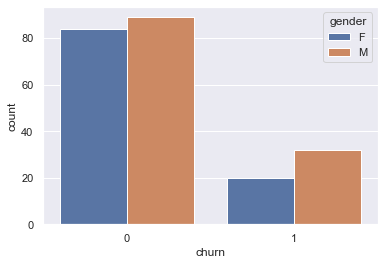

In [53]:
#distribution of churns users and normal users, deduplicated
show_gender_churn_dist()

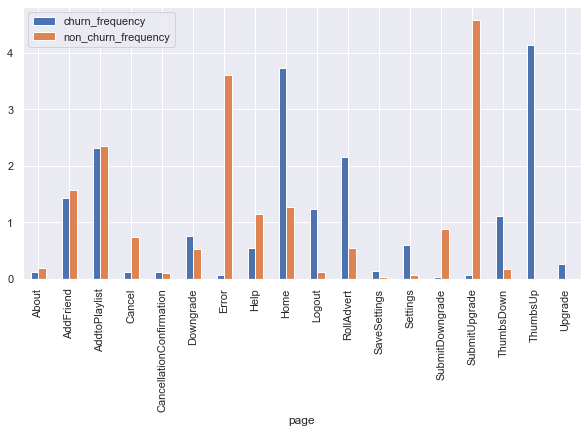

In [175]:
#distribution of page use for churn users and normal users
page_use_distribution()

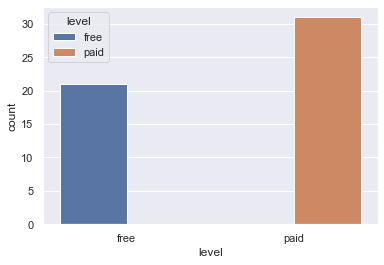

In [199]:
#payment plan when users churned
churn_level()

In [184]:
temp = churn_data.toPandas()
temp.page.unique()

array(['NextSong', 'AddtoPlaylist', 'RollAdvert', 'ThumbsUp', 'Downgrade',
       'ThumbsDown', 'Home', 'Logout', 'Help', 'Upgrade', 'AddFriend',
       'Settings', 'SubmitUpgrade', 'About', 'SubmitDowngrade', 'Error',
       'SaveSettings', 'Cancel', 'CancellationConfirmation'], dtype=object)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.